In [4]:
from dotenv import dotenv_values
from sec_edgar_downloader import Downloader
from os.path import isdir

TICKERS = ["AAPL", "MSFT"]
BASE_DIR = "./sec-edgar-filings"
config = dotenv_values(".env")
# Download Filings
dl = Downloader(config["COMPANY_NAME"], config["EMAIL_ADDRESS"])
for ticker in TICKERS:
    if not isdir(f"{BASE_DIR}/{ticker}"):
        print(f"Downloading {ticker}")
        dl.get("10-K", ticker, download_details=True)

Error occurred while downloading filing for accession number {}: {} 0001032210-00-001961 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/789019/000103221000001961/0001.txt


In [6]:
from bs4 import BeautifulSoup, NavigableString, CData, PageElement, Tag
import language_tool_python
from os import listdir
from unstructured.nlp.partition import is_possible_narrative_text
from unstructured.cleaners.core import (
    clean_extra_whitespace,
    group_broken_paragraphs,
    clean_non_ascii_chars,
    replace_unicode_quotes,
)


import re

UNICODE_RE = re.compile(r"&#\d{3};")
BACKSPACE_RE = re.compile(r"&nbsp;")
CHAR_ENT_RE = re.compile(r"&\w+;")
DOC_START_RE = re.compile(r"<DOCUMENT>")
DOC_END_RE = re.compile(r"</DOCUMENT>")
BLANK_LINES_RE = re.compile(r"(\n\s*){2,}")
PAGE_NUM_RE = re.compile(r"^\s*\d+\s*", re.MULTILINE)
DATE_RE = re.compile(r"CONFORMED PERIOD OF REPORT:\s*\d{8}")


#Filters BeaautifulSoup tags for Text Tags
def text_filter(element: PageElement):
    return type(element) in (NavigableString, CData)

#Filters BeaautifulSoup tags for Element Tags
def tag_filter(element: PageElement):
    return type(element) == Tag

#Parses text filing into BeautifulSoup
def parse_filing(filing: str) -> str:
    date = DATE_RE.search(filing).group()
    old = int(date[-8:-4]) <= 2001 and "<PAGE>" in filing
    text = UNICODE_RE.sub("", filing)
    text = BACKSPACE_RE.sub(" ", text)
    text = CHAR_ENT_RE.sub("", text)
    if old:
        text = re.sub(r"<C>", "", text)
        text = re.sub(r"<S>", "", text)
        text = re.sub(r"<CAPTION>", "", text)
        text = re.sub(r"^\s*\d+\s*\n", "", text, flags=re.MULTILINE)
    start = DOC_START_RE.search(text).start()
    *_, end = DOC_END_RE.finditer(text)
    text = replace_unicode_quotes(text[start : end.end()])
    text = f"<FILING>{date}</FILING>" + text
    soup = BeautifulSoup(text)
    for doc in soup.find_all("document"):
        type_tag = doc.find("type")
        if type_tag:
            doc_type = str(type_tag.contents[0]).strip()
        if doc_type in ("XML", "GRAPHIC", "ZIP", "EXCEL", "JSON") or doc.find("xbrl"):
            doc.decompose()
    return clean_filing(soup, old)

#Cleans text
def clean_text(element: PageElement) -> str:
    text = element.text
    if PAGE_NUM_RE.search(text) and "|" not in text:
        return ""
    if is_possible_narrative_text(text):
        text = group_broken_paragraphs(text)
    return text

#Returns clean filing from beautifulsoup
def clean_filing(filing: BeautifulSoup, old: bool) -> str:
    tags = filter(text_filter, filing.descendants)
    tables_old = []
    for table in filing.find_all("table"):
        if old:
            if len(table.find_all("article")) != 0:
                table.append(format_old_table(table))
            tables_old.append(table.get_text())
            table.string = "|TABLE|"
        else:
            table.append(format_new_table(table))
    if old:
        text = filing.get_text()
        cleaned = ""
        for chunk in text.split("\n\n"):
            chunk = clean_extra_whitespace(group_broken_paragraphs(chunk))
            cleaned += f"{chunk}\n\n"
        i = 0
        TABLE_RE = re.compile(r"\|TABLE\|")
        while match := TABLE_RE.search(cleaned):
            cleaned = cleaned[: match.start()] + tables_old[i] + cleaned[match.end() :]
            i += 1
        text = cleaned
    else:
        text = "\n".join(clean_text(s) for s in tags)
    text = BLANK_LINES_RE.sub("\n\n", text)
    return clean_non_ascii_chars(text)

#Converts html table to text
def format_new_table(element: PageElement) -> str:
    table = ""
    for row in filter(tag_filter, element.children):
        row_text = ""
        for cell in filter(tag_filter, row.children):
            cell_text = clean_extra_whitespace(cell.text) or "--"
            row_text += cell_text
            if cell_text != "$":
                row_text += "|"
        row.extract()
        if row_text:
            table += row_text[:-1] + "\n"
    return table + "\n"

#Converts old html table to text
def format_old_table(element: PageElement) -> str:
    table_text = ""
    curr = next(filter(tag_filter, element.find_all(True, recursive=False)))
    try:
        while True:
            curr.extract()
            if curr.name != "article":
                table_text += f"{curr.name}: {curr.contents[0]}"
            curr = next(filter(tag_filter, curr.find_all(True, recursive=False)))
    except:
        return table_text

#Goes through filings and cleans them
def write_filing(ticker: str, cik: str):
    print(f"Ticker:{ticker}, cik:{cik}")
    filing_path = f"{BASE_DIR}/{ticker}/10-K/{cik}/full-submission.txt"
    with open(filing_path, "r") as f:
        filing_text = f.read()
    parsed_text = parse_filing(filing_text)
    with language_tool_python.LanguageTool("en-US") as tool:
        cleaned_text = tool.correct(parsed_text)
    cleaned_path = f"{BASE_DIR}/{ticker}/10-K/{cik}/cleaned-submission.txt"
    with open(cleaned_path, "w") as f:
        f.write(clean_non_ascii_chars(cleaned_text))


for ticker in TICKERS:
    for cik in listdir(f'{BASE_DIR}/{ticker}/10-K/'):
        write_filing(ticker,cik)

Ticker:AAPL, cik:0000320193-17-000070
Ticker:AAPL, cik:0000320193-18-000145
Ticker:AAPL, cik:0000320193-19-000119
Ticker:AAPL, cik:0000320193-20-000096
Ticker:AAPL, cik:0000320193-21-000105
Ticker:AAPL, cik:0000320193-22-000108
Ticker:AAPL, cik:0000320193-23-000106
Ticker:AAPL, cik:0000320193-94-000016
Ticker:AAPL, cik:0000320193-95-000016
Ticker:AAPL, cik:0000320193-96-000023
Ticker:AAPL, cik:0000912057-00-053623
Ticker:AAPL, cik:0000912057-99-010244
Ticker:AAPL, cik:0001047469-02-007674
Ticker:AAPL, cik:0001047469-03-041604
Ticker:AAPL, cik:0001047469-04-035975
Ticker:AAPL, cik:0001047469-07-009340
Ticker:AAPL, cik:0001047469-97-006960
Ticker:AAPL, cik:0001104659-05-058421
Ticker:AAPL, cik:0001104659-06-084288
Ticker:AAPL, cik:0001193125-08-224958
Ticker:AAPL, cik:0001193125-09-214859
Ticker:AAPL, cik:0001193125-10-238044
Ticker:AAPL, cik:0001193125-11-282113
Ticker:AAPL, cik:0001193125-12-444068
Ticker:AAPL, cik:0001193125-13-416534
Ticker:AAPL, cik:0001193125-14-383437
Ticker:AAPL,

In [4]:
import chromadb
from llama_index.vector_stores.chroma import ChromaVectorStore
from llama_index.llms.anthropic import Anthropic
from llama_index.core import Settings, Document, VectorStoreIndex
from llama_index.core.ingestion import IngestionPipeline
from llama_index.core.postprocessor import LongContextReorder
from llama_index.postprocessor.cohere_rerank import CohereRerank
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.core.node_parser import TokenTextSplitter


import nest_asyncio

nest_asyncio.apply()

#Setup LLM Settings
Settings.embed_model = HuggingFaceEmbedding(
    model_name="BAAI/bge-small-en-v1.5", trust_remote_code=True
)
Settings.llm = Anthropic(
    "claude-3-sonnet-20240229", temperature=0.1, api_key=config["CLAUDE_API_KEY"]
)
Settings.tokenizer = Anthropic().tokenizer
documents = []

#Create documents for all the cleaned filings
for ticker in TICKERS:
    for cik in listdir(f"{BASE_DIR}/{ticker}/10-K/"):
        cleaned_path = f"{BASE_DIR}/{ticker}/10-K/{cik}/cleaned-submission.txt"
        with open(cleaned_path, "r") as f:
            doc_text = f.read()
        date = doc_text.split("\n", 1)[0][-8:-4]
        new_doc = Document(text=doc_text, metadata={"Company": ticker, "Date": date})
        documents.append(new_doc)

#Create vector db to store embeddings
db = chromadb.PersistentClient(path="./filing-embeddings")
chroma_collection = db.get_or_create_collection("sec-filings")
vector_store = ChromaVectorStore(chroma_collection=chroma_collection)
#Define document transformation
pipeline = IngestionPipeline(
    transformations=[
        TokenTextSplitter(
            chunk_size=1024,
            chunk_overlap=20,
            separator="\n",
        ),
        # TitleExtractor(llm=title_llm),
        Settings.embed_model,
    ],
    vector_store=vector_store,
)

#Transform and embed documents
pipeline.run(documents=documents, show_progress=True)
index = VectorStoreIndex.from_documents(
    documents, embed_model=Settings.embed_model, transformations=[splitter]
)
# index = VectorStoreIndex.from_vector_store(vector_store)

#Postprocessors for the RAG
cohere_rerank = CohereRerank(api_key=config["COHERE_API_KEY"], top_n=5)
reorder = LongContextReorder()

query_engine = index.as_query_engine(
    node_postprocessors=[cohere_rerank, reorder], similarity_top_k=10
)

c:\Users\Rohit\AppData\Local\Programs\Python\Python311\Lib\site-packages\pydantic\_internal\_fields.py:160: UserWarning: Field "model_id" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


In [12]:
#Asks LLM to infer risks based on the relevant filing using RAG
def get_risks(ticker: str, year: str) -> str:
    return query_engine.query(
        f"Based on the legal and regulatory risks identified from {ticker}'s {date} 10-K filing, determine the key legal/regulatory risks and return a list of the risks associated with their potential impact, likelihood, and outcome in a JSON format for a risk heat map. The acceptable values for impact are negligable, low, moderate, significant, and catastrophic. The acceptable values for likelihood are improbable, remote, occasional, probable, and frequent. For outcome, explain the risk, how it could occur, its potential impact, and where in the filing you derived the analysis from. The format should be [{{risk:..., impact:...,likelihood:...,outcome:...}},...]",
    )


heat_map = query_engine.query(
    "Based on the legal and regulatory risks identified from AAPL's 2023 10-K filing, determine the key legal/regulatory risks and return a list of the risks associated with their potential impact, likelihood, and outcome in a JSON format for a risk heat map. The acceptable values for impact are negligable, low, moderate, significant, and catastrophic. The acceptable values for likelihood are improbable, remote, occasional, probable, and frequent. For outcome, explain the risk, how it could occur, its potential impact, and where in the filing you derived the analysis from. The format should be [{risk:..., impact:...,likelihood:...,outcome:...},...]",
)

AAPL is subject to various legal proceedings and claims that arise in the ordinary course of business. While management does not believe any current proceedings would have a material adverse effect individually, an adverse outcome in multiple proceedings resolved in the same period could materially impact operating results for that period. This risk is identified in the Legal and Other Contingencies section.
AAPL records contingent liabilities when a loss is probable and reasonably estimable. However, there is significant judgment involved in determining probability and estimating exposures. An incorrect judgment could lead to unreserved liabilities impacting financial results. This risk is noted in the Legal and Other Contingencies section.
AAPL's tax positions involve significant judgment, and the final determination of tax audits and litigation could differ from estimates, potentially having a material effect on financial position, results, or cash flows in the impacted period. This

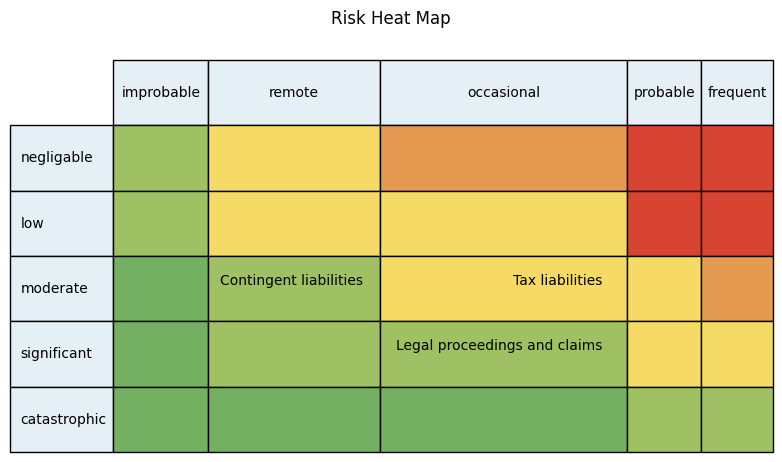

In [13]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Convert LLM response to dictionary
data = str(heat_map)
list_start = data.find("[")
list_end = data.rfind("]")
risk_factors = json.loads(data[list_start : list_end + 1])

impact_map = {
    "negligable": 0,
    "low": 1,
    "moderate": 2,
    "significant": 3,
    "catastrophic": 4,
}
likelihood_map = {
    "improbable": 0,
    "remote": 1,
    "occasional": 2,
    "probable": 3,
    "frequent": 4,
}

table_arr = [["" for _ in range(5)] for _ in range(5)]
# Map LLM output to risk heat map position
for risk_factor in risk_factors:
    impact = impact_map[risk_factor["impact"]]
    likelihood = likelihood_map[risk_factor["likelihood"]]
    table_arr[impact][likelihood] = (
        table_arr[impact][likelihood] + risk_factor["risk"] + "\n"
    )

cmap = [
    ["#74b062", "#74b062", "#74b062", "#a0c163", "#a0c163"],
    ["#a0c163", "#f5db65", "#f5db65", "#d84432", "#d84432"],
    ["#74b062", "#a0c163", "#f5db65", "#f5db65", "#e49a51"],
    ["#74b062", "#a0c163", "#a0c163", "#f5db65", "#f5db65"],
    ["#a0c163", "#f5db65", "#e49a51", "#d84432", "#d84432"],
]
header_colors = plt.cm.BuPu(np.full(5, 0.1))

plt.figure(
    linewidth=2,
    tight_layout={"pad": 1},
    # figsize=(5,3)
)
ax = plt.gca()
# Create the table
risk_table = plt.table(
    cellText=table_arr,
    rowLabels=list(impact_map.keys()),
    colLabels=list(likelihood_map.keys()),
    rowColours=header_colors,
    colColours=header_colors,
    cellColours=cmap,
    loc="center",
)

risk_table.auto_set_column_width(range(5))
plt.suptitle("Risk Heat Map")
# ax.set_title("Risk Heat Map", fontsize=16)
ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)
risk_table.scale(1, 5)
plt.box(on=None)
# Draw Heat map
plt.show()